Trying to use sympy as a replacement for mathematica to get my ODEs, then solving hte geodesic equaiton numerically


In [260]:
from sympy import Function, dsolve, Derivative, checkodesol,Symbol,diff, symbols
from sympy.abc import x
from sympy import MatrixSymbol, Matrix, Array
import sympy.diffgeom as dg
from sympy.diffgeom import Manifold, Patch, TensorProduct
import numpy as np
import sympy as sym
from sympy import simplify

m=Manifold('M',3)
p=Patch('P',m)



t,phi,r = symbols('t phi r')
tp,phip,rp = symbols(("\dot{t}", "\dot{\phi}","\dot{r}" ))
tpp,phipp,rpp =symbols("t'' phi'' r''")

coords=[t,phi,r]
coordsp=[tp,phip,rp]
coordspp=[tpp,phipp,rpp]

BL=dg.CoordSystem('Boyer-Lindquist',p,[t,phi,r])



s=Symbol('s')
a=Symbol('a')



In [261]:
def Delta(r):
    delta=r**2 + a**2-r*s
    return delta

def P(r):
    p=E*(r**2 + a**2) - a*L
    return p

def R(r):
    R=-Delta(r)*((L-a*E)**2+m**2)+P(r)**2
    return R

In [262]:
tt=-(1-s/r)
tphi=-a*s/r
phiphi=r**2+a**2+a**2*s/r
rr=r**2/Delta(r)

metric_components = Matrix([[tt,tphi,0],[tphi,phiphi,0],[0,0,rr]])
(dt,dphi,dr)=BL.base_oneforms()

metric = tt*TensorProduct(dt,dt) +tphi*TensorProduct(dt,dphi)+ tphi*TensorProduct(dphi,dt)+phiphi*TensorProduct(dphi,dphi)+rr*TensorProduct(dr,dr)


print(metric_components)

print(dg.twoform_to_matrix(metric))
metric

Matrix([[-1 + s/r, -a*s/r, 0], [-a*s/r, a**2 + a**2*s/r + r**2, 0], [0, 0, r**2/(a**2 + r**2 - r*s)]])
Matrix([[-1 + s/r, -a*s/r, 0], [-a*s/r, a**2 + a**2*s/r + r**2, 0], [0, 0, r**2/(a**2 + r**2 - r*s)]])


-a*s*TensorProduct(dt, dphi)/r - a*s*TensorProduct(dphi, dt)/r + r**2*TensorProduct(dr, dr)/(a**2 + r**2 - r*s) + (-1 + s/r)*TensorProduct(dt, dt) + (a**2 + a**2*s/r + r**2)*TensorProduct(dphi, dphi)

That's encouraging

In [263]:
christ=dg.metric_to_Christoffel_2nd(metric)
#this shit do not be working
#seems to be fundamentally broken, so I'll do it myself



In [264]:
from sympy.tensor.array import MutableDenseNDimArray
def christoffel_single(metric_matrix,coords,index1,index2,index3):
    dim=len(coords)
    partialsum=0
    for beta in range(dim):
        partialsum += 1/2*metric_matrix.inv()[index1,beta]*(diff(metric_matrix[beta,index2],coords[index3])+diff(metric_matrix[beta,index3],coords[index2])-diff(metric_matrix[index2,index3],coords[beta]))
    christf_single=partialsum
    return christf_single

def christoffel_symbols(metric,coords):
    dim=len(coords)
    christoffel_total=MutableDenseNDimArray.zeros(dim,dim,dim)
    
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                christoffel_total[i,j,k]=christoffel_single(metric,coords,i,j,k)
    return christoffel_total
    
    
    


In [265]:
christoff_pretty=simplify(christoffel_symbols(metric_components,coords))
christoff_pretty

[[[0, 0, 0.5*s*(a**2 + r**2)/(r**2*(a**2 + r**2 - r*s))], [0, 0, -0.5*a*s*(a**2 + 3*r**2)/(r**2*(a**2 + r**2 - r*s))], [0.5*s*(a**2 + r**2)/(r**2*(a**2 + r**2 - r*s)), -0.5*a*s*(a**2 + 3*r**2)/(r**2*(a**2 + r**2 - r*s)), 0]], [[0, 0, 0.5*a*s/(r**2*(a**2 + r**2 - r*s))], [0, 0, 1.0*(-0.5*a**2*s + 1.0*r**3 - 1.0*r**2*s)/(r**2*(a**2 + r**2 - r*s))], [0.5*a*s/(r**2*(a**2 + r**2 - r*s)), 1.0*(-0.5*a**2*s + 1.0*r**3 - 1.0*r**2*s)/(r**2*(a**2 + r**2 - r*s)), 0]], [[0.5*s*(a**2 + r**2 - r*s)/r**4, 0.5*a*s*(-a**2 - r**2 + r*s)/r**4, 0], [0.5*a*s*(-a**2 - r**2 + r*s)/r**4, 0.5*(a**2*s - 2*r**3)*(a**2 + r**2 - r*s)/r**4, 0], [0, 0, 1.0*(1.0*a**2 - 0.5*r*s)/(r*(a**2 + r**2 - r*s))]]]

IT FINALLY WORKED


In [266]:
def geod_second_deriv(coordinate,coords,coord_derivs,christoffel_symbols_all):
    dim=len(coords)
    coordIndex=coords.index(coordinate)
    
    expression=0
    for i in range(dim):
        for j in range(dim):
            expression+=-christoffel_symbols_all[coordIndex,i,j]*coord_derivs[i]*coord_derivs[j]
    return expression

z=Symbol('z')


t_second_der=simplify(geod_second_deriv(t,coords,coordsp,christoff_pretty))
simplify(t_second_der)

1.0*\dot{r}*s*(\dot{\phi}*a*(a**2 + 3*r**2) - \dot{t}*(a**2 + r**2))/(r**2*(a**2 + r**2 - r*s))

In [267]:
phi_second_der=simplify(geod_second_deriv(phi,coords,coordsp,christoff_pretty))
phi_second_der


\dot{r}*(2.0*\dot{\phi}*(0.5*a**2*s - 1.0*r**3 + 1.0*r**2*s) - 1.0*\dot{t}*a*s)/(r**2*(a**2 + r**2 - r*s))

In [268]:
r_second_der=simplify(geod_second_deriv(r,coords,coordsp,christoff_pretty))
r_second_der

(\dot{r}**2*r**3*(-1.0*a**2 + 0.5*r*s) + (a**2 + r**2 - r*s)**2*(-0.5*\dot{\phi}**2*(a**2*s - 2*r**3) + 1.0*\dot{\phi}*\dot{t}*a*s - 0.5*\dot{t}**2*s))/(r**4*(a**2 + r**2 - r*s))

In [269]:
from sympy.utilities.lambdify import lambdify

variablestuple=(t,phi,r,tp,phip,rp,a,s)
tpp_num=lambdify(variablestuple,t_second_der)
phipp_num=lambdify(variablestuple,phi_second_der)
rpp_num=lambdify(variablestuple,r_second_der)



tpp_num(t,phi,r,tp,phip,rp,a,s)

1.0*\dot{r}*s*(\dot{\phi}*a*(a**2 + 3*r**2) - \dot{t}*(a**2 + r**2))/(r**2*(a**2 + r**2 - r*s))

In [274]:
import math
#define functions we will need 
def Delta(r):
    delta=r**2 + a**2-r*s
    return delta

def P(r):
    p=E*(r**2 + a**2) - a*L
    return p

def R(r):
    R=-Delta(r)*((L-a*E)**2+m**2)+P(r)**2
    return R
#black hole params
a=0.998 #BH spin param
M=1 #BH mass param
s=2*M #BH schwartzchild radius

#horizon radii
r_h=(s+np.sqrt(s**2-4*a**2))/2
r_hi=(s-np.sqrt(s**2-4*a**2))/2

#ergoregion (valid only in equatorial plane)
r_e=2*M
r_ei=0

#test particle
m=0 #particle mass
r_0=3 #initial radial pos
rp_0=0.0 #initial radial (pseudo?)momentum

phi_0=0 #initial angular pos
phip_0=-0.05#initial angular (pseudo?)momentum

t_0=0
tp_0=(-a*s*phip_0/r_0+math.sqrt(a*a*s*phip_0*phip_0/r_0 + (1-s/r_0)*(m**2 + (r_0**2+a**2)*phip_0**2 + (r_0*rp_0)**2/Delta(r_0))))/(1-s/r_0)
tp_0


0.39965011255625704

In [275]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

def EOM(t,y):
    t=y[0]
    phi=y[1]
    r=y[2]
    dt=y[3]
    dphi=y[4]
    dr=y[5]
    
    
    dtprime=tpp_num(t,phi,r,dt,dphi,dr,a,s)
    dphiprime=phipp_num(t,phi,r,dt,dphi,dr,a,s)
    drprime=rpp_num(t,phi,r,dt,dphi,dr,a,s)

    
    
    dxmu=np.array([dt,dphi,dr,dtprime,dphiprime,drprime])
    return dxmu

lambda0=0

lambda_max=100000



y0=np.array([0,0,r_0,tp_0,phip_0,rp_0])


RK=scipy.integrate.RK45(EOM,lambda0,y0,lambda_max,max_step=0.001)

In [276]:
step_max=10000000
xmu=np.zeros((step_max,6))
xmu[0,:]=y0

reachedstep=0
for lambstep in range(1,step_max):
    try:
        RK.step()   
        xmu[lambstep,:]=RK.y
        reachedstep=lambstep
    except RuntimeError:
        break
    finally:
        if(xmu[lambstep,2] <1.02*r_h):
            break
        if(xmu[lambstep,2] > 10*r_0):
            break
        
x_trunc=xmu[0:reachedstep,:] #x without the trailing zero rows

Text(0.5, 1.0, 'Oblate Spheroidal Pseudoradius')

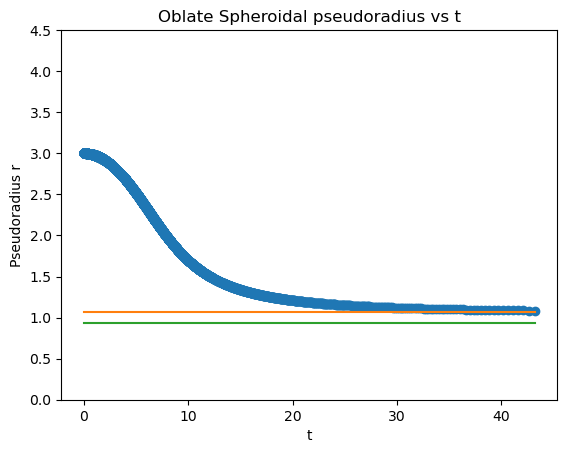

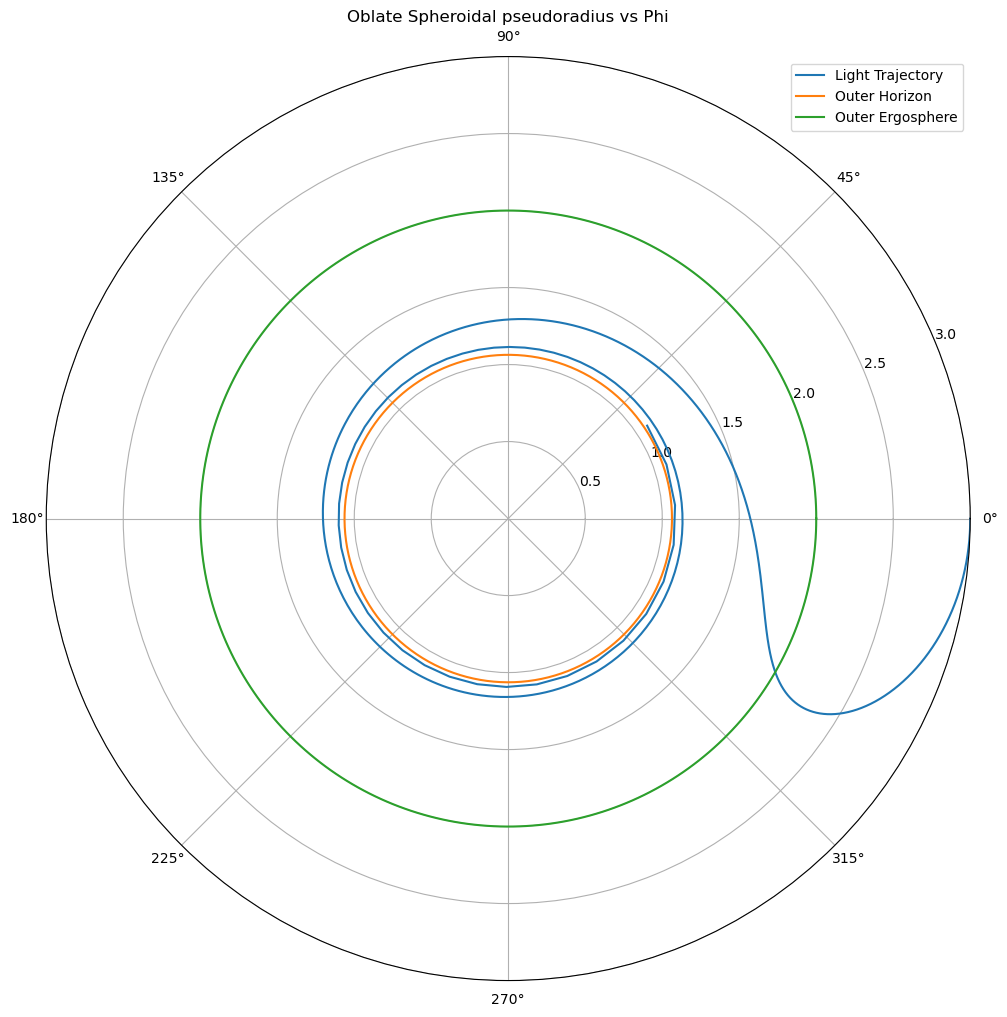

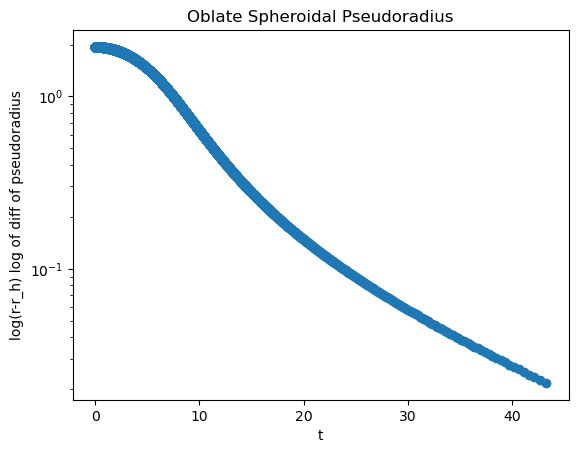

In [278]:
tmin=np.min(x_trunc[:,0])
tmax=np.max(x_trunc[:,0])

plt.plot(x_trunc[:,0],x_trunc[:,2],'-o')
plt.plot([tmin, tmax],[r_h,r_h])
plt.plot([tmin, tmax],[r_hi,r_hi])
plt.xlabel("t")
plt.ylabel("Pseudoradius r")
plt.title("Oblate Spheroidal pseudoradius vs t")
plt.ylim([0,r_0*1.5])
#polar plot
fig2, ax2 = plt.subplots(figsize=(12,12),subplot_kw={'projection':'polar'})

#setup horizon plotting
numpts=300
th_hor=np.linspace(0,2*np.pi,num=numpts)
ones_arr=np.ones((numpts))
rh_arr=ones_arr*r_h
rhi_arr=ones_arr*r_hi
re_arr=ones_arr*r_e
#plot trajecory
ax2.plot(x_trunc[:,1],x_trunc[:,2],label='Light Trajectory')
#plot horizon
ax2.plot(th_hor,rh_arr,label='Outer Horizon')
ax2.plot(th_hor,re_arr,label='Outer Ergosphere')
#ax2.plot(th_hor,rhi_arr)
plt.title("Oblate Spheroidal pseudoradius vs Phi")
plt.ylim([0,r_0*1])
plt.legend()


plt.figure()
plt.semilogy(x_trunc[:,0],x_trunc[:,2]-r_h,'-o')
plt.xlabel("t")
plt.ylabel("log(r-r_h) log of diff of pseudoradius")
plt.title("Oblate Spheroidal Pseudoradius")